In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
from torch import nn
import torch.nn.functional as F
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from typing import Union
from ml_utilities.torch_models.base_model import BaseModel
from ml_utilities.torch_models.fc import FC
from ml_utilities.torch_models import get_model_class
from omegaconf import OmegaConf

from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
gpu_id = 0

/system/apps/userenv/beck/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load matrix

In [2]:
p = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs'
dir_matrix = load_directions_matrix_from_task_sweep(p, device=gpu_id)
dir_matrix.requires_grad_(False)

Loading /system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs/f_mnist-2.0-taskidx3-seed0_260622_110648:  90%|█████████ | 9/10 [00:03<00:00,  2.46it/s]


tensor([[-0.0005, -0.0005, -0.0004,  ..., -0.0032,  0.0077, -0.0123],
        [-0.0044, -0.0045, -0.0043,  ..., -0.0023,  0.0065, -0.0126],
        [-0.0035, -0.0035, -0.0034,  ...,  0.0005,  0.0075, -0.0096],
        ...,
        [-0.0034, -0.0034, -0.0034,  ..., -0.0009,  0.0030, -0.0107],
        [-0.0011, -0.0011, -0.0012,  ..., -0.0041,  0.0075, -0.0082],
        [-0.0046, -0.0046, -0.0050,  ..., -0.0013,  0.0027, -0.0132]],
       device='cuda:0')

In [3]:
dir_matrix.shape, dir_matrix.device, dir_matrix.requires_grad

(torch.Size([10, 669706]), device(type='cuda', index=0), False)

## erank function

In [4]:
def erank(matrix_A: torch.Tensor, center_matrix_A: bool=False) -> torch.Tensor:
        """Calculates the effective rank of a matrix.

        Args:
            matrix_A (torch.Tensor): Matrix of shape m x n. 
            center_matrix_A (bool): Center the matrix 

        Returns:
            torch.Tensor: Effective rank of matrix_A
        """
        assert matrix_A.ndim == 2
        _, s, _ = torch.pca_lowrank(matrix_A, center=center_matrix_A, niter=1, q=min(matrix_A.shape[0], matrix_A.shape[1]))
        # s = torch.square(s) / (s.shape[0] - 1)

        # normalizes input s -> scale independent!
        return torch.exp(torch.distributions.Categorical(s).entropy())

In [5]:
er = erank(dir_matrix)
er

tensor(9.1032, device='cuda:0')

In [6]:
# er.backward()

## What happens to the effective rank of the directions matrix, if we normalize the matrix?

The effective rank changes barely. 
Reason: The vectors in the matrix have about the same norm. 
Directions of vectors do not change

In [7]:
norm_dir_matrix = dir_matrix / torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True)

In [8]:
# torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True), torch.linalg.norm(norm_dir_matrix, ord=2, dim=1, keepdim=True)

In [9]:
erank(dir_matrix), erank(norm_dir_matrix)

(tensor(9.1032, device='cuda:0'), tensor(9.1280, device='cuda:0'))

## Analyze the different pretrained runs: How similar are they? Is the mean vector a good representative?

This experiment is the start to answer the question: What happens to the model parameters for high erank weights?
The goal is to relate the parameters found by erank regularization with the regular trained networks (there we know we found a good local optimum by standard neural network training). Somehow the optimum found by training with erank regularization seems to be better in terms of accuracy. Why is that the case? Where does this optimum lie in relation to the "standard" optimum / optima?

Approach: We want to compare the parameters to the fixed pretrained models. 
Metrics:
- use the normalized erank (to verify that the model is in the subspace!)
- use L2 distance to pretrained model to compare model norms
- use cosine similarity to pretrained models

In [10]:

#! Does mean vector (model) lie in subspace?
mean_dir = dir_matrix.mean(dim=0, keepdim=True)
mean_dir.shape

# verify that erank does not increase
matrix0 = torch.cat([dir_matrix, mean_dir], dim=0)
norm_matrix0 = matrix0 / torch.linalg.norm(matrix0, ord=2, dim=1, keepdim=True)
erank(matrix0), erank(norm_matrix0)
#! the erank is slightly smaller with the mean vector appended? Why is that? Expectation: erank stays constant (same as rank of Matrix in 2d)

(tensor(9.0129, device='cuda:0'), tensor(8.9479, device='cuda:0'))

In [11]:
# calculate cosine similarity of every vector to mean vector?
# cosine similarity: gives the angle between two vectors, is always in the interval [-1,1], orthogonal vectors have similarity of 0, proportional vectors have similarity of 1, opposite vectors have -1
# expect: cosine similarity close to 1 (however in high dimensions vectors can easily be orthogonal) -> Do experiment!

F.cosine_similarity(dir_matrix[0, None], dir_matrix[1, None])
F.cosine_similarity(dir_matrix[0, None], mean_dir)

tensor([0.6951], device='cuda:0')

In [12]:
# make a matrix plot of similarity between models
from erank.plot import plot_similarity_to_mean_model, plot_similarity_between_models

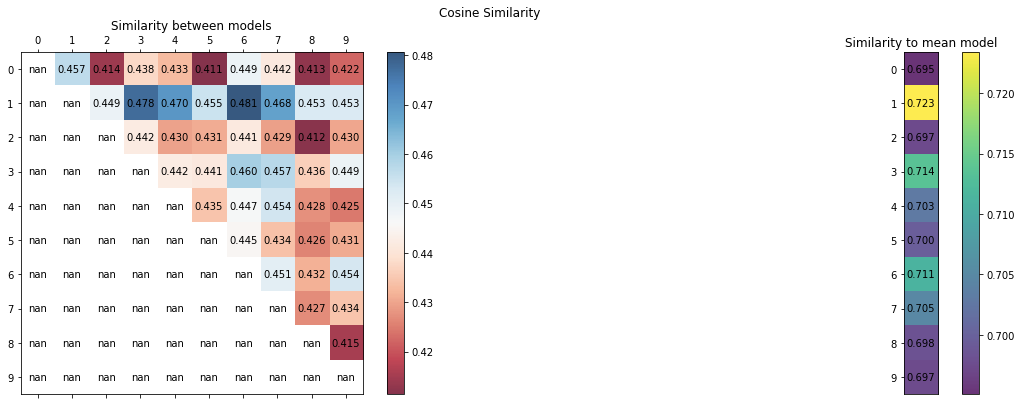

In [13]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(4 * 12 * 1 / 2.54, 2 * 8 * 1 / 2.54))
sim_func = lambda model1, model2 : F.cosine_similarity(model1, model2, dim=0)
fig_title='Cosine Similarity'
ax = plot_similarity_between_models(model_matrix=dir_matrix, similarity_function=sim_func, fig_ax=(fig,ax0), fig_title=fig_title)
ax = plot_similarity_to_mean_model(model_matrix=dir_matrix, similarity_function=sim_func, fig_ax=(fig, ax1), fig_title=fig_title)

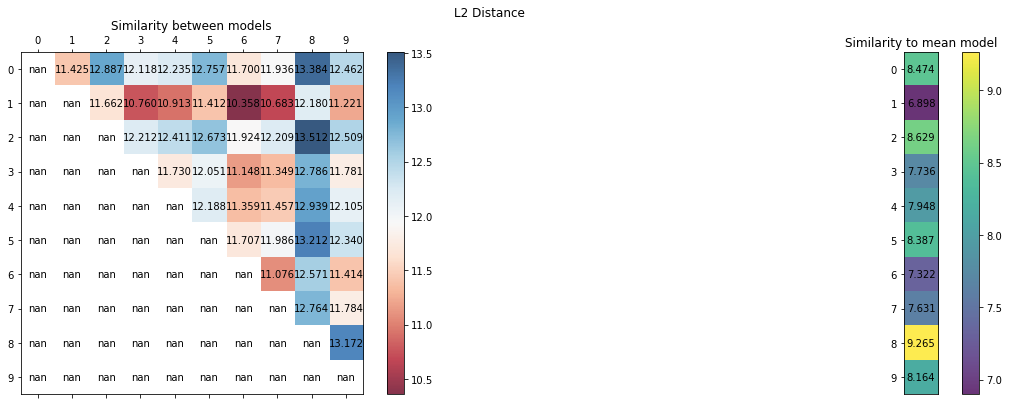

In [14]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(4 * 12 * 1 / 2.54, 2 * 8 * 1 / 2.54))
sim_func = lambda model1, model2 : torch.linalg.norm(model1-model2, ord=2)
fig_title='L2 Distance'
ax = plot_similarity_between_models(model_matrix=dir_matrix, similarity_function=sim_func, fig_ax=(fig,ax0), fig_title=fig_title)
ax = plot_similarity_to_mean_model(model_matrix=dir_matrix, similarity_function=sim_func, fig_ax=(fig, ax1), fig_title=fig_title)

**Conclusion**: Similarity to mean model is 